# 03 — Modeling (Linear Regression for NBA Win%)

**Input:** `data/clean_team_stats.csv` (auto-builds from `data/combined_team_stats.csv` if missing)  
**Outputs:**
- `images/top_positive_coeffs.png`
- `images/top_negative_coeffs.png`
- `model/win_predictor.pkl`
- `model/scaler.pkl`
- `model/features.csv`
- `model/metrics.json`


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

# Resolve folders whether notebook runs at repo root or /notebooks
DATA   = Path("data")   if Path("data").exists()   else Path("../data")
IMAGES = Path("images") if Path("images").exists() else Path("../images")
MODEL  = Path("model")  if Path("model").exists()  else Path("../model")
IMAGES.mkdir(exist_ok=True)
MODEL.mkdir(exist_ok=True)

DATA.resolve(), IMAGES.resolve(), MODEL.resolve()


(WindowsPath('C:/Users/jeff/Documents/nba-win-predictor/data'),
 WindowsPath('C:/Users/jeff/Documents/nba-win-predictor/images'),
 WindowsPath('C:/Users/jeff/Documents/nba-win-predictor/model'))

In [2]:
from pathlib import Path
DATA = Path("data") if Path("data").exists() else Path("../data")
print("DATA:", DATA.resolve())
print("Has combined?", (DATA/"combined_team_stats.csv").exists())
print("Has clean?",    (DATA/"clean_team_stats.csv").exists())
out = DATA/"clean_team_stats.csv"
df.to_csv(out, index=False)
print("Wrote:", out.resolve(), "shape:", df.shape)

DATA: C:\Users\jeff\Documents\nba-win-predictor\data
Has combined? True
Has clean? False


In [5]:
# Try to load clean dataset; if missing, build it from combined
try:
    df = pd.read_csv(DATA / "clean_team_stats.csv")
    print("Loaded clean:", (DATA/"clean_team_stats.csv").resolve())
except FileNotFoundError:
    print("No clean file found. Building from combined_team_stats.csv...")
    df = pd.read_csv(DATA / "combined_team_stats.csv")

    # Target & basic fields
    df["games"] = df["wins"] + df["losses"]
    df = df[df["games"] > 0]
    df["win_pct"] = df["wins"] / df["games"]

    # numeric coercion (keep ids)
    id_cols = ["team","season"]
    for c in df.columns:
        if c not in id_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # derive net_rating if missing
    if "net_rating" not in df.columns and {"ortg","drtg"}.issubset(df.columns):
        df["net_rating"] = df["ortg"] - df["drtg"]

    # drop very-missing columns, then fill remaining NA with medians
    num_cols = [c for c in df.columns if c not in id_cols]
    drop_cols = df[num_cols].isna().mean()[lambda s: s > 0.40].index.tolist()
    if drop_cols:
        df = df.drop(columns=drop_cols)

    for c in [c for c in df.columns if c not in id_cols]:
        if df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())

    # light outlier trim on rate-like columns
    rate_like = [c for c in df.columns if c.endswith("pct") or "rating" in c or c in ["pace","win_pct"]]
    for c in rate_like:
        if c in df.columns:
            q1, q99 = df[c].quantile([0.001, 0.999])
            df = df[df[c].between(q1, q99)]

    # save clean
    out = DATA / "clean_team_stats.csv"
    df.to_csv(out, index=False)
    print("Wrote clean:", out.resolve(), "shape:", df.shape)

df.head(3), df.shape


Loaded clean: C:\Users\jeff\Documents\nba-win-predictor\data\clean_team_stats.csv


(             team  season  wins  losses  pace   ortg   drtg  net_rating   srs  \
 0  Atlanta Hawks*    2014  38.0    44.0  94.6  105.9  106.4        -0.5 -0.88   
 1  Boston Celtics    2014  25.0    57.0  93.3  102.9  107.7        -4.8 -4.97   
 2  Brooklyn Nets*    2014  44.0    38.0  91.4  106.7  107.7        -1.0 -1.58   
 
    threepar    ftr  ft_fga  games   win_pct  
 0     0.316  0.266   0.208   82.0  0.463415  
 1     0.251  0.248   0.193   82.0  0.304878  
 2     0.301  0.313   0.236   82.0  0.536585  ,
 (355, 14))

In [6]:
# Target
y = df["win_pct"]

# Drop identifiers / leak-prone columns
drop_cols = {"team","season","wins","losses","games","win_pct"}
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].copy()

print("Features:", len(feature_cols))
feature_cols[:12]


Features: 8


['pace', 'ortg', 'drtg', 'net_rating', 'srs', 'threepar', 'ftr', 'ft_fga']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_s.shape, X_test_s.shape


((284, 8), (71, 8))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import json

model = LinearRegression()
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)

# metrics (version-agnostic)
r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# simple baseline: predict train mean
baseline = np.repeat(y_train.mean(), len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline))

print(f"R²: {r2:.3f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Baseline RMSE: {baseline_rmse:.4f}")



R²: 0.937 | RMSE: 0.0359 | MAE: 0.0295 | Baseline RMSE: 0.1443


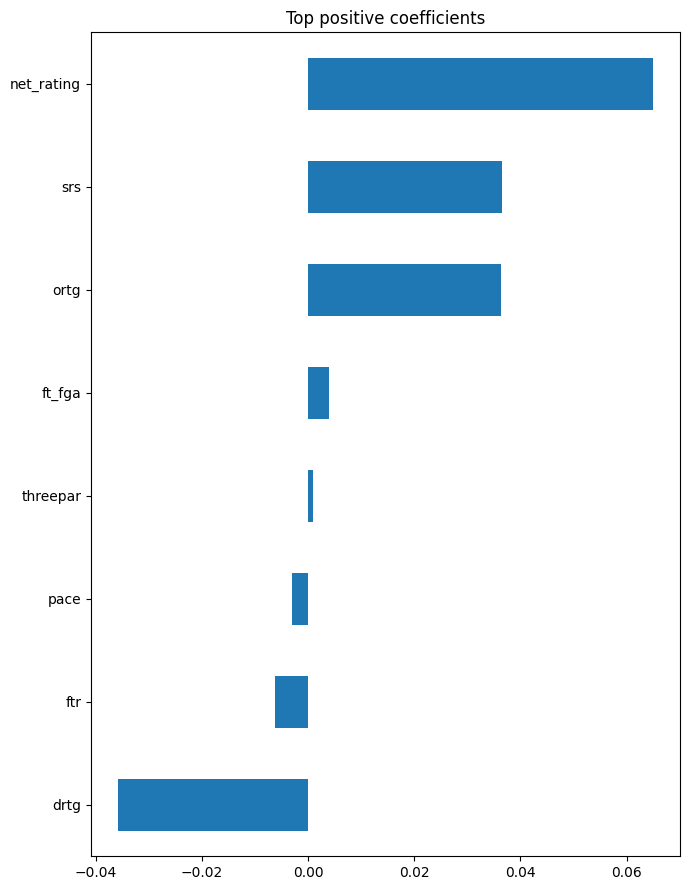

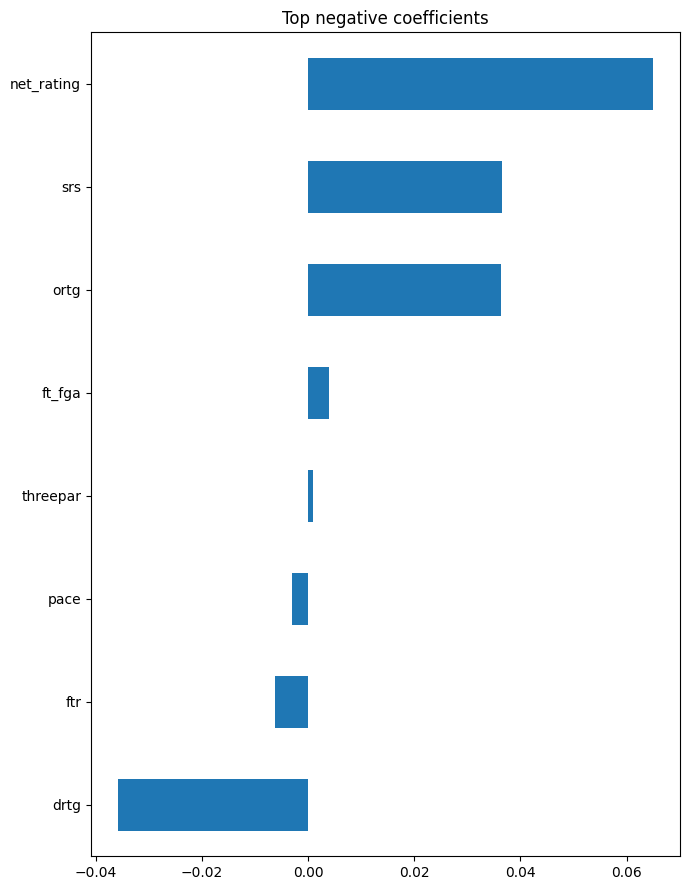

(WindowsPath('images/top_positive_coeffs.png'),
 WindowsPath('images/top_negative_coeffs.png'))

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

coefs = pd.Series(model.coef_, index=feature_cols).sort_values()

# top positive
plt.figure(figsize=(7,9))
coefs.tail(12).plot(kind="barh", title="Top positive coefficients")
plt.tight_layout()
pos_path = IMAGES / "top_positive_coeffs.png"
plt.savefig(pos_path, dpi=200)
plt.show()

# top negative
plt.figure(figsize=(7,9))
coefs.head(12).plot(kind="barh", title="Top negative coefficients")
plt.tight_layout()
neg_path = IMAGES / "top_negative_coeffs.png"
plt.savefig(neg_path, dpi=200)
plt.show()

pos_path, neg_path


In [11]:
import joblib

joblib.dump(model, MODEL / "win_predictor.pkl")
joblib.dump(scaler, MODEL / "scaler.pkl")
pd.Series(feature_cols).to_csv(MODEL / "features.csv", index=False)

metrics = {"r2": float(r2), "rmse": float(rmse), "mae": float(mae), "baseline_rmse": float(baseline_rmse)}
(MODEL / "metrics.json").write_text(json.dumps(metrics, indent=2))

"saved"


'saved'